# Xception Model Training

This notebook contains model training process for Xception model on three different deepfake detection datasets. The model training splitted into two parts, which are baseline model (base model without dropout) and the dropout model itself.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, xception
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import pickle
import os

## Define Dataset Directory

In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC"

In [3]:
cdf_train_dir = os.path.join(CDF_DATASET_DIR, "Train")
cdf_val_dir = os.path.join(CDF_DATASET_DIR, "Val")

df_train_dir = os.path.join(DF_DATASET_DIR, "Train")
df_val_dir = os.path.join(DF_DATASET_DIR, "Val")

dfdc_train_dir = os.path.join(DFDC_DATASET_DIR, "Train")
dfdc_val_dir = os.path.join(DFDC_DATASET_DIR, "Val")

## Image Data Generator for Each Dataset

In [4]:
def create_image_generator(dataset_dir):
    datagen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)
    image_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(128, 128),
        batch_size=32,
        color_mode="rgb",
        class_mode="binary",
        shuffle=True,
        seed=42
    )

    return image_generator

In [5]:
print("Celeb-DF-v2 Dataset")
cdf_train_generator = create_image_generator(cdf_train_dir)
cdf_val_generator = create_image_generator(cdf_val_dir)

print("\nDeeperForensics-1.0 Dataset")
df_train_generator = create_image_generator(df_train_dir)
df_val_generator = create_image_generator(df_val_dir)

print("\nDeepfake Detection Challenge Dataset")
dfdc_train_generator = create_image_generator(dfdc_train_dir)
dfdc_val_generator = create_image_generator(dfdc_val_dir)

Celeb-DF-v2 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

DeeperForensics-1.0 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

Deepfake Detection Challenge Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Get the Best Hyperparameters from Tuner

In [6]:
TUNER_RESULT_DIR = "/kaggle/input/hyperparameter-tuning/tuner_result"
BASE_HP_TUNER_PROJECT_NAME = "base_hp"
DROPOUT_TUNER_PROJECT_NAME = "dropout_rate"

In [7]:
def get_best_hp_from_tuner(tuner_dir, project_name):
    tuner = kt.Hyperband(directory=tuner_dir,
                         project_name=project_name,
                         overwrite=False)

    best_hp = tuner.get_best_hyperparameters()[0].values
    return best_hp

### Base Hyperparameters

In [8]:
best_base_hp = get_best_hp_from_tuner(TUNER_RESULT_DIR, BASE_HP_TUNER_PROJECT_NAME)
best_base_hp

Reloading Tuner from /kaggle/input/hyperparameter-tuning/tuner_result/base_hp/tuner0.json


{'conv_layers': 4,
 'conv_1_filters': 256,
 'conv_2_filters': 224,
 'conv_3_filters': 256,
 'conv_1_kernel_size': 3,
 'conv_2_kernel_size': 3,
 'conv_3_kernel_size': 3,
 'dense_layers': 4,
 'dense_1_layer_units': 64,
 'dense_2_layer_units': 224,
 'learning_rate': 1e-05,
 'conv_4_filters': 256,
 'conv_4_kernel_size': 7,
 'dense_3_layer_units': 224,
 'dense_4_layer_units': 224,
 'dense_5_layer_units': 224,
 'conv_5_filters': 192,
 'conv_5_kernel_size': 3,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

### Dropout Hyperparameter

In [9]:
best_dropout_hp = get_best_hp_from_tuner(TUNER_RESULT_DIR, DROPOUT_TUNER_PROJECT_NAME)
best_dropout_hp

Reloading Tuner from /kaggle/input/hyperparameter-tuning/tuner_result/dropout_rate/tuner0.json


{'dropout_rate': 0.65,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

### Combine All Hyperparameters into a Dict

In [10]:
best_hp = {}

best_hp["conv_layers"] = best_base_hp.get("conv_layers")
for i in range(best_base_hp.get("conv_layers")):
    conv_filter_hp_name = f"conv_{i+1}_filters"
    conv_kernel_size_hp_name = f"conv_{i+1}_kernel_size"
    best_hp[conv_filter_hp_name] = best_base_hp.get(conv_filter_hp_name)
    best_hp[conv_kernel_size_hp_name] = best_base_hp.get(conv_kernel_size_hp_name)

best_hp["dense_layers"] = best_base_hp.get("dense_layers")
for i in range(best_base_hp.get("dense_layers")):
    dense_unit_hp_name = f"dense_{i+1}_layer_units"
    best_hp[dense_unit_hp_name] = best_base_hp.get(dense_unit_hp_name)

best_hp["dropout_rate"] = best_dropout_hp.get("dropout_rate")
best_hp["learning_rate"] = best_base_hp.get("learning_rate")

print("Best hyperparameters loaded\n")
for key in best_hp:
    print(f"{key}: {best_hp[key]}")

Best hyperparameters loaded

conv_layers: 4
conv_1_filters: 256
conv_1_kernel_size: 3
conv_2_filters: 224
conv_2_kernel_size: 3
conv_3_filters: 256
conv_3_kernel_size: 3
conv_4_filters: 256
conv_4_kernel_size: 7
dense_layers: 4
dense_1_layer_units: 64
dense_2_layer_units: 224
dense_3_layer_units: 224
dense_4_layer_units: 224
dropout_rate: 0.65
learning_rate: 1e-05


## Function to Create an Xception Model

In [11]:
def create_xception_model(hp, dropout=False):
    base_model = Xception(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = tf.keras.Sequential()
    model.add(base_model)

    model.add(tf.keras.layers.Flatten())

    for i in range(hp.get("dense_layers")):
        dense_units = hp.get(f"dense_{i+1}_layer_units")
        model.add(tf.keras.layers.Dense(dense_units, activation="relu"))

    if dropout:
        model.add(tf.keras.layers.Dropout(hp.get("dropout_rate")))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.get("learning_rate")),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )

    return model

## Function to Plot Train Results

In [12]:
def plot_train_result(history, title="Training Result"):
    plt.figure(figsize=(12, 4))
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Train")
    plt.plot(history["val_accuracy"], label="Val")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Function to Save Model Training History

In [13]:
def save_model_and_history(model, history, model_name):
    model_filename = f"{model_name}_model.keras"
    history_filename = f"{model_name}_history.pkl"

    model.save(model_filename)
    print(f"Model saved at {model_filename}")    

    with open(history_filename, "wb") as f:
        pickle.dump(history.history, f)
        print(f"Training history saved at {history_filename}")

## Model Training

In [14]:
NUM_EPOCHS = 50

### Baseline Xception

#### Celeb-DF-v2 Dataset

In [15]:
baseline_xception_cdf_model = create_xception_model(best_hp)
baseline_xception_cdf_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [16]:
baseline_xception_cdf_history = baseline_xception_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730780675.783823     256 service.cc:145] XLA service 0x7f0d98002f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730780675.783884     256 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/438 ━━━━━━━━━━━━━━━━━━━━ 1:20:34 11s/step - accuracy: 0.4688 - loss: 0.7014

I0000 00:00:1730780680.288296     256 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 97s 198ms/step - accuracy: 0.5719 - loss: 0.6792 - val_accuracy: 0.6295 - val_loss: 0.6460
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7653 - loss: 0.5393 - val_accuracy: 0.6225 - val_loss: 0.6916
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.8619 - loss: 0.3764 - val_accuracy: 0.6370 - val_loss: 0.7438
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.8983 - loss: 0.2804 - val_accuracy: 0.6620 - val_loss: 0.7908
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9306 - loss: 0.2108 - val_accuracy: 0.6645 - val_loss: 0.8131
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9533 - loss: 0.1562 - val_accuracy: 0.6730 - val_loss: 0.8457
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9591 - loss: 0.1316 - val_accuracy: 0.6815 - val_loss: 0.8371
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9715 - loss: 0.1023 - val_accura

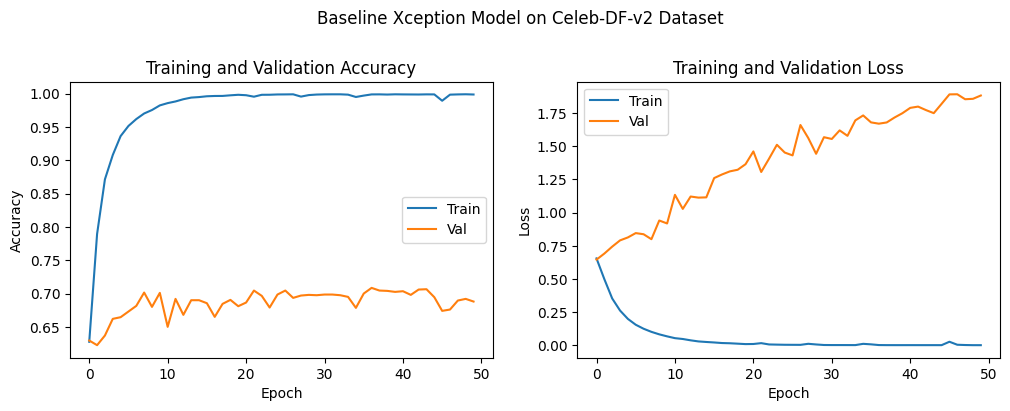

In [17]:
plot_train_result(
    baseline_xception_cdf_history.history,
    title="Baseline Xception Model on Celeb-DF-v2 Dataset"
)

In [18]:
save_model_and_history(
    baseline_xception_cdf_model, baseline_xception_cdf_history, "baseline_xception_cdf"
)

Model saved at baseline_xception_cdf_model.keras
Training history saved at baseline_xception_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [19]:
baseline_xception_df_model = create_xception_model(best_hp)
baseline_xception_df_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [20]:
baseline_xception_df_history = baseline_xception_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 107s 225ms/step - accuracy: 0.7182 - loss: 0.5686 - val_accuracy: 0.7505 - val_loss: 0.4589
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 74s 76ms/step - accuracy: 0.9600 - loss: 0.1734 - val_accuracy: 0.7700 - val_loss: 0.4636
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.9839 - loss: 0.0736 - val_accuracy: 0.8070 - val_loss: 0.4249
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.9913 - loss: 0.0410 - val_accuracy: 0.8340 - val_loss: 0.4145
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.9952 - loss: 0.0265 - val_accuracy: 0.8315 - val_loss: 0.4566
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.9969 - loss: 0.0178 - val_accuracy: 0.8455 - val_loss: 0.4462
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9975 - loss: 0.0134 - val_accuracy: 0.8530 - val_loss: 0.4329
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.9987 - loss: 0.0093 

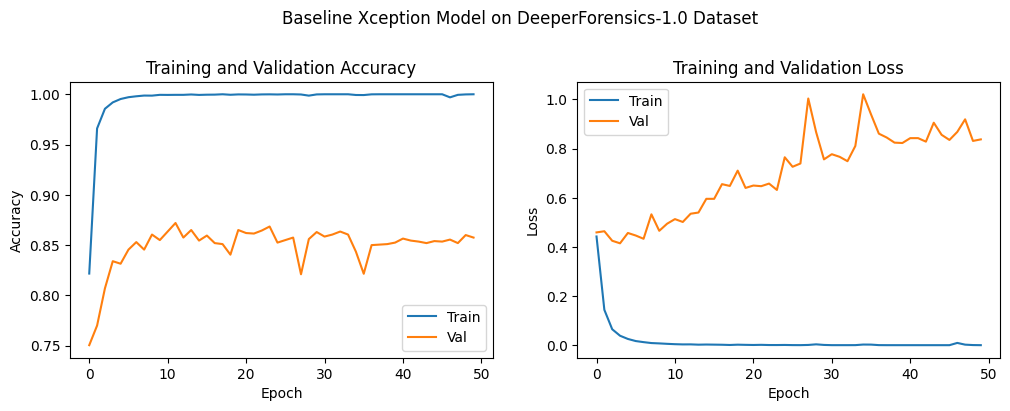

In [21]:
plot_train_result(
    baseline_xception_df_history.history,
    title="Baseline Xception Model on DeeperForensics-1.0 Dataset"
)

In [22]:
save_model_and_history(
    baseline_xception_df_model, baseline_xception_df_history, "baseline_xception_df"
)

Model saved at baseline_xception_df_model.keras
Training history saved at baseline_xception_df_history.pkl


#### DFDC Dataset

In [23]:
baseline_xception_dfdc_model = create_xception_model(best_hp)
baseline_xception_dfdc_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [24]:
baseline_xception_dfdc_history = baseline_xception_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 117s 248ms/step - accuracy: 0.6353 - loss: 0.6550 - val_accuracy: 0.5265 - val_loss: 0.7245
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 53s 50ms/step - accuracy: 0.8540 - loss: 0.4084 - val_accuracy: 0.5420 - val_loss: 0.8500
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9306 - loss: 0.2304 - val_accuracy: 0.5605 - val_loss: 0.9426
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9559 - loss: 0.1461 - val_accuracy: 0.5295 - val_loss: 1.2208
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9708 - loss: 0.1000 - val_accuracy: 0.5430 - val_loss: 1.2226
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9782 - loss: 0.0744 - val_accuracy: 0.5240 - val_loss: 1.3605
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.9833 - loss: 0.0593 - val_accuracy: 0.5315 - val_loss: 1.3582
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.9874 - loss: 0.0451 

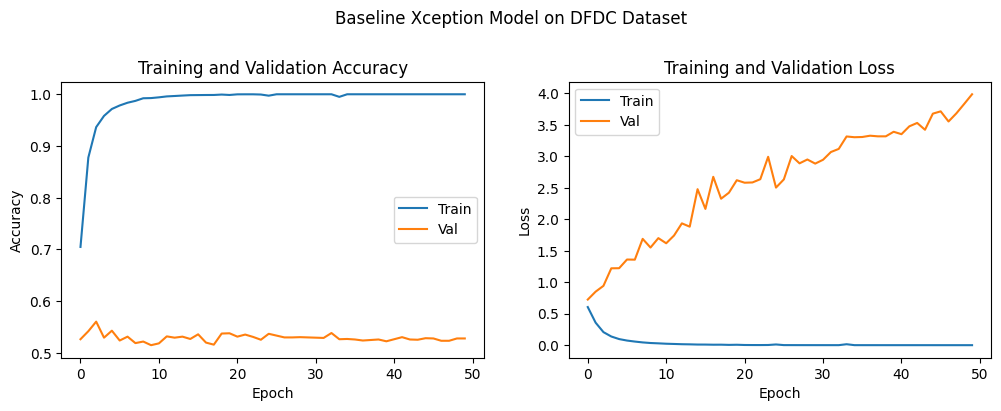

In [25]:
plot_train_result(
    baseline_xception_dfdc_history.history,
    title="Baseline Xception Model on DFDC Dataset"
)

In [26]:
save_model_and_history(
    baseline_xception_dfdc_model, baseline_xception_dfdc_history, "baseline_xception_dfdc"
)

Model saved at baseline_xception_dfdc_model.keras
Training history saved at baseline_xception_dfdc_history.pkl


### Dropout Xception Model Training

#### Celeb-DF-v2 Dataset

In [27]:
dropout_xception_cdf_model = create_xception_model(best_hp, dropout=True)
dropout_xception_cdf_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [28]:
dropout_xception_cdf_history = dropout_xception_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 103ms/step - accuracy: 0.5391 - loss: 0.6885 - val_accuracy: 0.5395 - val_loss: 0.6796
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.6534 - loss: 0.6377 - val_accuracy: 0.5990 - val_loss: 0.6516
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.7701 - loss: 0.5235 - val_accuracy: 0.6150 - val_loss: 0.6894
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8384 - loss: 0.4035 - val_accuracy: 0.6535 - val_loss: 0.7203
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.8886 - loss: 0.3050 - val_accuracy: 0.6645 - val_loss: 0.7487
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9161 - loss: 0.2376 - val_accuracy: 0.6660 - val_loss: 0.7662
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.9395 - loss: 0.1857 - val_accuracy: 0.6825 - val_loss: 0.7900
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.9451 - loss: 0.1623 -

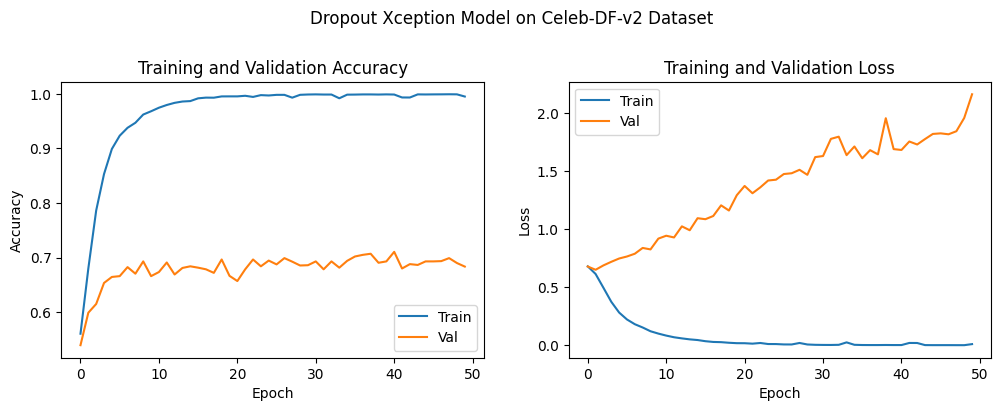

In [29]:
plot_train_result(
    dropout_xception_cdf_history.history,
    title="Dropout Xception Model on Celeb-DF-v2 Dataset"
)

In [30]:
save_model_and_history(
    dropout_xception_cdf_model, dropout_xception_cdf_history, "dropout_xception_cdf"
)

Model saved at dropout_xception_cdf_model.keras
Training history saved at dropout_xception_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [31]:
dropout_xception_df_model = create_xception_model(best_hp, dropout=True)
dropout_xception_df_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [32]:
dropout_xception_df_history = dropout_xception_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 52s 98ms/step - accuracy: 0.6507 - loss: 0.6109 - val_accuracy: 0.6960 - val_loss: 0.5237
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.9210 - loss: 0.2442 - val_accuracy: 0.7320 - val_loss: 0.5105
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.9698 - loss: 0.1057 - val_accuracy: 0.7820 - val_loss: 0.4748
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.9852 - loss: 0.0585 - val_accuracy: 0.8155 - val_loss: 0.4554
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.9882 - loss: 0.0411 - val_accuracy: 0.8140 - val_loss: 0.4977
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.9927 - loss: 0.0297 - val_accuracy: 0.8225 - val_loss: 0.4967
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - accuracy: 0.9957 - loss: 0.0208 - val_accuracy: 0.8295 - val_loss: 0.4933
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.9948 - loss: 0.0170 - 

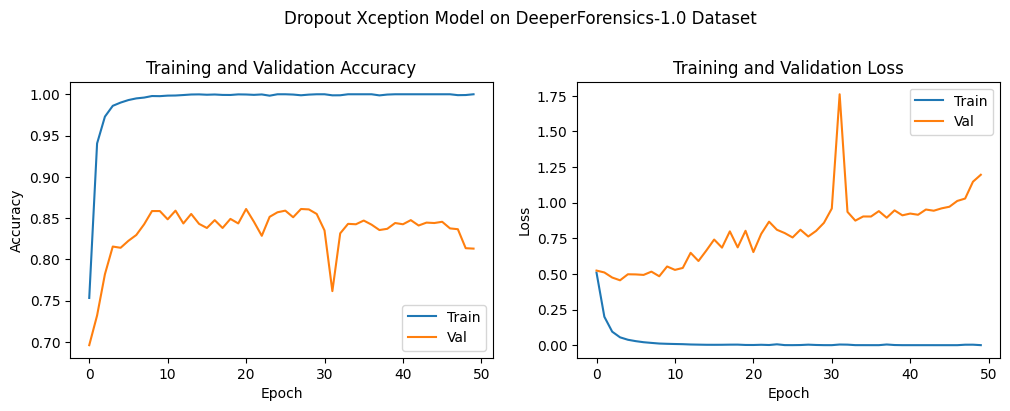

In [33]:
plot_train_result(
    dropout_xception_df_history.history,
    title="Dropout Xception Model on DeeperForensics-1.0 Dataset"
)

In [34]:
save_model_and_history(
    dropout_xception_df_model, dropout_xception_df_history, "dropout_xception_df"
)

Model saved at dropout_xception_df_model.keras
Training history saved at dropout_xception_df_history.pkl


#### DFDC Dataset

In [35]:
dropout_xception_dfdc_model = create_xception_model(best_hp, dropout=True)
dropout_xception_dfdc_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [36]:
dropout_xception_dfdc_history = dropout_xception_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 51s 97ms/step - accuracy: 0.5688 - loss: 0.6742 - val_accuracy: 0.5370 - val_loss: 0.7000
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - accuracy: 0.7555 - loss: 0.5411 - val_accuracy: 0.5385 - val_loss: 0.7586
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - accuracy: 0.8700 - loss: 0.3570 - val_accuracy: 0.5125 - val_loss: 0.9082
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.9246 - loss: 0.2331 - val_accuracy: 0.5230 - val_loss: 1.0384
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 75s 168ms/step - accuracy: 0.9480 - loss: 0.1641 - val_accuracy: 0.5380 - val_loss: 1.0950
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 71s 160ms/step - accuracy: 0.9618 - loss: 0.1252 - val_accuracy: 0.5155 - val_loss: 1.2421
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.9735 - loss: 0.0896 - val_accuracy: 0.4910 - val_loss: 1.4765
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9796 - loss: 0.07

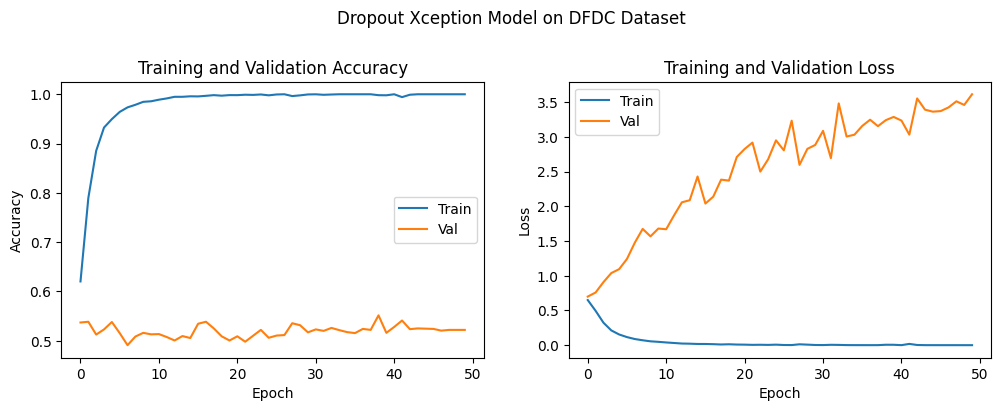

In [37]:
plot_train_result(
    dropout_xception_dfdc_history.history,
    title="Dropout Xception Model on DFDC Dataset"
)

In [38]:
save_model_and_history(
    dropout_xception_dfdc_model, dropout_xception_dfdc_history, "dropout_xception_dfdc"
)

Model saved at dropout_xception_dfdc_model.keras
Training history saved at dropout_xception_dfdc_history.pkl
